In [34]:
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import winsound
from scipy import signal
import librosa
import librosa.display
from scipy.ndimage import gaussian_filter1d

In [35]:
wav_file = os.path.join(os.getcwd(), '..', 'metronome_test', 'test_bpm_60.wav')

44100 Hz


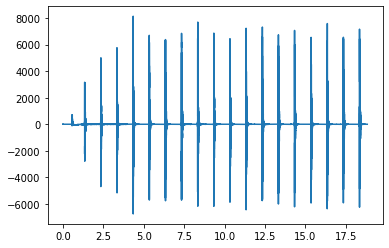

In [36]:
fs, data = wavfile.read(wav_file)
print(f"{fs} Hz")

# winsound.PlaySound(wav_file, winsound.SND_FILENAME)

audio = np.mean(data, axis=1)

time = np.linspace(0, len(audio) / fs, len(audio))
plt.plot(time, audio)
plt.show()

# Onset Strength Envelope

Resampled to 8000 Hz


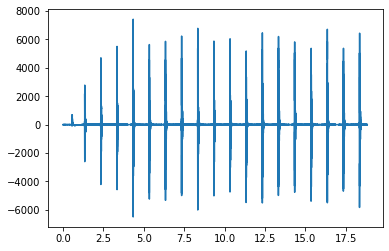

In [37]:
new_fs = 8000
print(f"Resampled to {new_fs} Hz")
f = signal.resample(audio, int(round((len(audio) / fs) * new_fs)))

scaled_f = np.int16(f/np.max(np.abs(f)) * 32767)

wav_file_resamp = os.path.join(os.getcwd(), '..', 'test_bpm_resamp.wav')
# wavfile.write(wav_file_resamp, new_fs, scaled_f)

# winsound.PlaySound(wav_file_resamp, winsound.SND_FILENAME)

time = np.linspace(0, len(f) / new_fs, len(f))
plt.plot(time, f)
plt.show()

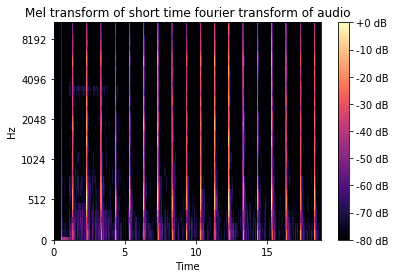

In [38]:
window_len = int(round(0.032 * new_fs))
overlap_len = int(round(0.004 * new_fs))

n_mels = 40
S = librosa.feature.melspectrogram(f, sr=new_fs, n_fft=window_len, 
                                   hop_length=overlap_len, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
plt.title('Mel transform of short time fourier transform of audio')
librosa.display.specshow(S_DB, sr=new_fs, hop_length=overlap_len, 
                         x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

60.75607560756076


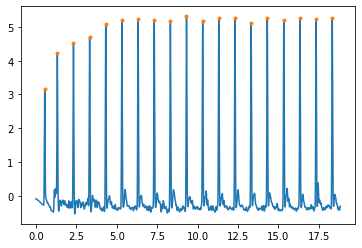

In [39]:
# First order difference in band power against time
S_DB_diff = np.diff(S_DB, axis=1)
# Negative differences set to zero
S_DB_diff_rect = S_DB_diff.copy()
S_DB_diff_rect[S_DB_diff_rect < 0] = 0
# Positive differences summed over bands
band_sum = np.sum(S_DB_diff_rect, axis=0)

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# High pass filter applied to signal
spect_fs = new_fs / overlap_len
band_sum_smooth = butter_highpass_filter(band_sum, 0.4, spect_fs, order=3)

# Smooth with gaussian convolution
gauss_std = 0.02 * spect_fs
band_sum_smooth = gaussian_filter1d(band_sum_smooth, gauss_std)
onset_strengths = band_sum_smooth / np.std(band_sum_smooth)
time = np.linspace(0, len(onset_strengths) / spect_fs, len(onset_strengths))
plt.plot(time, onset_strengths)

peaks = signal.find_peaks(onset_strengths, prominence=2)
plt.plot(time[peaks[0]], onset_strengths[peaks[0]], '.')
print(60 / (np.mean(np.diff(peaks[0])) / spect_fs))

# Global Tempo Estimate

C:\Users\Danie\Anaconda3\envs\music\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Danie\Anaconda3\envs\music\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


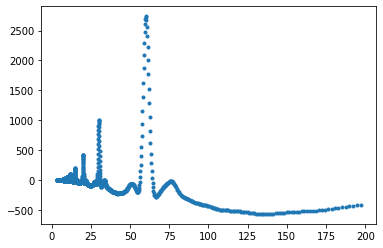

In [40]:
# suggested values
period_bias = 0.4
weighting_width = 1.4

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(round(result.size/2)):]

autocorrelation = autocorr(onset_strengths)
periods = np.linspace(0, len(autocorrelation) / spect_fs, len(autocorrelation))
weights = np.exp(-0.5 * (np.log2(periods / period_bias) / weighting_width)**2)

period_strengths = weights * autocorrelation
bpms = [60 / period for period in periods]
bpms = np.flip(bpms)
period_strengths = np.flip(period_strengths)
N = np.argmin(abs(bpms - 200))
plt.plot(bpms[:N], period_strengths[:N], '.')
plt.show()

# Find BPM Peak

In [41]:
peaks = signal.find_peaks(period_strengths, prominence=400)
peak_tempos = [bpms[peak] for peak in peaks[0]]
peak_tempo = bpms[peaks[0][int(np.argmax(peaks[1]['prominences']))]]
print(f"Predicted Tempo: {int(round(peak_tempo))} bpm")

Predicted Tempo: 60 bpm
